In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import softmax
import torch

def svd(m):
    return np.linalg.svd(m, compute_uv=False)

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
from logger import create_logger
import os


from utils import load_checkpoint, load_pretrained
from config import get_config
from data import build_loader
from models import build_model

from config import get_only_config
import json
import copy
import math

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


In [3]:
# f = open('config_export.json')
# config = json.load(f)

In [4]:
config_path = 'configs/swin/swin_tiny_patch4_window7_224_resisc45.yaml'
config = get_only_config(config_path)

=> merge config from configs/swin/swin_tiny_patch4_window7_224_resisc45.yaml


In [5]:
config.defrost()
config.OUTPUT = "/afs/ece.cmu.edu/usr/bmarimut/Private/output"
config.MODEL.PRETRAINED = "/afs/ece.cmu.edu/usr/ashwinve/Public/ckpt_epoch_29_6.pth"
config.freeze()
os.makedirs(config.OUTPUT, exist_ok=True)
logger = create_logger(output_dir=config.OUTPUT, name=f"{config.MODEL.NAME}")


In [6]:
print(config)

AMP_ENABLE: False
AMP_OPT_LEVEL: 
AUG:
  AUTO_AUGMENT: rand-m9-mstd0.5-inc1
  COLOR_JITTER: 0.4
  CUTMIX: 1.0
  CUTMIX_MINMAX: None
  MIXUP: 0.0
  MIXUP_MODE: batch
  MIXUP_PROB: 1.0
  MIXUP_SWITCH_PROB: 0.5
  RECOUNT: 1
  REMODE: pixel
  REPROB: 0.25
BASE: ['']
DATA:
  BATCH_SIZE: 4
  CACHE_MODE: no
  DATASET: resisc45
  DATA_PATH: 
  IMG_SIZE: 224
  INTERPOLATION: bicubic
  MASK_PATCH_SIZE: 32
  MASK_RATIO: 0.6
  NUM_WORKERS: 1
  PIN_MEMORY: False
  ZIP_MODE: True
ENABLE_AMP: False
EVAL_MODE: False
FUSED_LAYERNORM: False
FUSED_WINDOW_PROCESS: False
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.2
  DROP_RATE: 0.0
  LABEL_SMOOTHING: 0.0
  NAME: swin_tiny_patch4_window7_224_resisc45
  NUM_CLASSES: 45
  PRETRAINED: /afs/ece.cmu.edu/usr/ashwinve/Public/ckpt_epoch_29_6.pth
  RESUME: 
  SIMMIM:
    NORM_TARGET:
      ENABLE: False
      PATCH_SIZE: 47
  SWIN:
    APE: False
    DEPTHS: [2, 2, 6, 2]
    EMBED_DIM: 96
    FREEZE_AUTHOR_METHOD: False
    FREEZE_LAYERS: True
    FREEZE_LAYER_INDEX: 

In [7]:
model = build_model(config)

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
load_pretrained(config, model, logger)

[2022-12-06 17:36:07 swin_tiny_patch4_window7_224_resisc45](utils.py 58): INFO ==============> Loading weight /afs/ece.cmu.edu/usr/ashwinve/Public/ckpt_epoch_29_6.pth for fine-tuning......
[2022-12-06 17:36:10 swin_tiny_patch4_window7_224_resisc45](utils.py 139): WARNING _IncompatibleKeys(missing_keys=['layers.0.blocks.0.attn.relative_position_index', 'layers.0.blocks.1.attn_mask', 'layers.0.blocks.1.attn.relative_position_index', 'layers.1.blocks.0.attn.relative_position_index', 'layers.1.blocks.1.attn_mask', 'layers.1.blocks.1.attn.relative_position_index', 'layers.2.blocks.0.attn.relative_position_index', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.1.attn.relative_position_index', 'layers.2.blocks.2.attn.relative_position_index', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.3.attn.relative_position_index', 'layers.2.blocks.4.attn.relative_position_index', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.5.attn.relative_position_index', 'layers.3.blocks.0.attn.relative_position

In [9]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [10]:
model.state_dict().keys()

odict_keys(['patch_embed.proj.weight', 'patch_embed.proj.bias', 'patch_embed.norm.weight', 'patch_embed.norm.bias', 'layers.0.blocks.0.norm1.weight', 'layers.0.blocks.0.norm1.bias', 'layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.0.attn.relative_position_index', 'layers.0.blocks.0.attn.qkv.weight', 'layers.0.blocks.0.attn.qkv.bias', 'layers.0.blocks.0.attn.proj.weight', 'layers.0.blocks.0.attn.proj.bias', 'layers.0.blocks.0.norm2.weight', 'layers.0.blocks.0.norm2.bias', 'layers.0.blocks.0.mlp.fc1.weight', 'layers.0.blocks.0.mlp.fc1.bias', 'layers.0.blocks.0.mlp.fc2.weight', 'layers.0.blocks.0.mlp.fc2.bias', 'layers.0.blocks.1.attn_mask', 'layers.0.blocks.1.norm1.weight', 'layers.0.blocks.1.norm1.bias', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_index', 'layers.0.blocks.1.attn.qkv.weight', 'layers.0.blocks.1.attn.qkv.bias', 'layers.0.blocks.1.attn.proj.weight', 'layers.0.blocks.1.attn.proj.bias', 'layers.0.blo

In [23]:
layers_3_blocks_0_attn_qkv_weight = model.state_dict()['layers.3.blocks.0.attn.qkv.weight']

In [12]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

    return windows

In [13]:

LAYER_DEPTHS = [2, 2, 6, 2]
NUM_LAYERS = len(LAYER_DEPTHS)
NUM_HEADS = [ 3, 6, 12, 24 ]
i = 3
H = 224
W = 224
B = 1
L = 224 * 224
C = 96 * 2**i
num_heads = NUM_HEADS[i]
dim = C
window_size = 7

# x = np.random.rand(B, H, W, C)
x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)))
# x = np.random.normal(size=(B, H, W, C))

x_windows = window_partition(x, window_size)

In [15]:
class attn_model(torch.nn.Module):
    def __init__(self, i, H, W, B, L, C, num_heads, window_size, dim):
        super(attn_model, self).__init__()
        
        self.i = i
        self.H = H
        self.W = W
        self.B = B
        self.L = L
        self.C = C
        self.num_heads = num_heads
        self.window_size = window_size
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        proj_drop = 0


        self.qkv_layer = torch.nn.Linear(C, C * 3, bias=True)
        self.relative_position_bias_table = torch.nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # self.proj = torch.nn.Linear(dim, dim)
        # self.proj_drop = torch.nn.Dropout(proj_drop)

        self.softmax = torch.nn.Softmax(dim=-1)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)


    def load_pretrained_weights(self, params_names_list, super_model):
        new_sd = copy.deepcopy(self.state_dict())
        for name in params_names_list:
            new_sd['qkv_layer.weight'] = super_model.state_dict()[name+'.qkv.weight']
            new_sd['qkv_layer.bias'] = super_model.state_dict()[name+'.qkv.bias']
        
        new_sd['relative_position_bias_table'] = super_model.state_dict()[name+'.relative_position_bias_table']
        
        self.load_state_dict(new_sd)

    def forward(self, x):
        x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, self.C)
        B_, N_, C_ = x_windows.shape
        #  Xn @ x_windows
        print(" x_windows shape ", x_windows.shape)
        qkv = self.qkv_layer(x_windows)
        qkv = qkv.reshape(B_, N_, 3, num_heads, C_ // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        print(" q : ", q.shape)
        print(" k : ", k.shape)
        print(" v : ", v.shape)
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        print("attn : ", attn.shape)
        x = (attn @ v).transpose(1, 2).reshape(B_, N_, C_)
        # x = self.proj(x)
        # x = self.proj_drop(x)
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        flops = 0
        # transform : k @ lora_k
        # flops += k.shape[0] * k.shape[1] * 2 * k.shape[2] * k.shape[3] * k_lora.shape[3]
        # attn: q @ k_lora
        flops += q.shape[0] * q.shape[1] * 2 * q.shape[2] * q.shape[3] * k.transpose(-2, -1).shape[3]
        # transform : v @ v_lora
        # flops += v.shape[0] * v.shape[1] * 2 * v.shape[2] * v.shape[3] * v_lora.shape[3]
        # op : attn @ v_lora
        flops += attn.shape[0] * attn.shape[1] * 2 * attn.shape[2] * attn.shape[3] * v.shape[3]

        return self.softmax(attn), q, k, v, x, flops


In [15]:
out_dict = {}

cutoff_across_windows = 80
cutoff_across_heads_1 = 80
cutoff_across_heads_2 = 90


for layer_id in range(NUM_LAYERS):
    for block_id in range(LAYER_DEPTHS[layer_id]):
        C = 96 * 2**layer_id
        num_heads = NUM_HEADS[layer_id]
        dim = C
        my_model = attn_model(layer_id, H, W, B, L, C, num_heads, window_size, dim)
        param_name = ['layers.' + str(layer_id) + ".blocks." + str(block_id) + ".attn"]
        print(param_name)
        my_model.load_pretrained_weights(param_name, model)
        x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)), dtype=torch.float)
        attn_op, q, k, v, x = my_model(x)
        attn_op = attn_op.detach().numpy()
        attn_op = attn_op.transpose(1, 0, 2, 3)
        across_heads_x = []
        for j in range(0, attn_op.shape[0], 1):
            x = []
            y = []
            for i in range(0, attn_op.shape[1], 1):
                a = np.cumsum(svd(attn_op[j][i]))
                # print(len(a))
                idx = np.argmax(a)
                x.append(idx)
                y.append(a[idx])
                # plt.plot(a[idx], label = "attn output")
            across_heads_x.append(np.percentile(x,cutoff_across_windows))
            out_dict[param_name[0]] = [np.mean(across_heads_x), np.percentile(across_heads_x, cutoff_across_heads_1), np.percentile(across_heads_x, cutoff_across_heads_2)]

['layers.0.blocks.0.attn']
 x_windows shape  torch.Size([1024, 49, 96])
 q :  torch.Size([1024, 3, 49, 32])
 k :  torch.Size([1024, 3, 49, 32])
 v :  torch.Size([1024, 3, 49, 32])
attn :  torch.Size([1024, 3, 49, 49])


ValueError: too many values to unpack (expected 5)

In [29]:
out_dict

{'layers.0.blocks.0.attn': [9.0, 12.000000000000002, 13.0],
 'layers.0.blocks.1.attn': [28.333333333333332, 35.400000000000006, 38.2],
 'layers.1.blocks.0.attn': [24.333333333333332, 32.0, 39.0],
 'layers.1.blocks.1.attn': [19.0, 22.0, 23.0],
 'layers.2.blocks.0.attn': [16.333333333333332, 18.0, 18.900000000000002],
 'layers.2.blocks.1.attn': [19.5, 21.8, 22.0],
 'layers.2.blocks.2.attn': [21.583333333333332, 25.6, 29.6],
 'layers.2.blocks.3.attn': [21.916666666666668, 25.200000000000003, 26.0],
 'layers.2.blocks.4.attn': [23.5, 23.8, 24.9],
 'layers.2.blocks.5.attn': [22.75, 23.8, 24.0],
 'layers.3.blocks.0.attn': [20.208333333333332, 21.0, 22.4],
 'layers.3.blocks.1.attn': [16.225000000000005, 16.0, 17.280000000000065]}

In [31]:
mean_dict = {}
for layer_name in out_dict.keys():
    mean_dict[layer_name] = math.floor(out_dict[layer_name][0])

In [32]:
mean_dict

{'layers.0.blocks.0.attn': 9,
 'layers.0.blocks.1.attn': 28,
 'layers.1.blocks.0.attn': 24,
 'layers.1.blocks.1.attn': 19,
 'layers.2.blocks.0.attn': 16,
 'layers.2.blocks.1.attn': 19,
 'layers.2.blocks.2.attn': 21,
 'layers.2.blocks.3.attn': 21,
 'layers.2.blocks.4.attn': 23,
 'layers.2.blocks.5.attn': 22,
 'layers.3.blocks.0.attn': 20,
 'layers.3.blocks.1.attn': 16}

In [16]:
my_model = attn_model(i, H, W, B, L, C, num_heads, window_size, C)

In [17]:
# params_names = ['layers.1.blocks.0.attn']
params_names = ['layers.3.blocks.0.attn']
my_model.load_pretrained_weights(params_names, model)

In [18]:
x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)), dtype=torch.float)
attn_op, q, k, v, x, no_lora_flops = my_model(x)

 x_windows shape  torch.Size([1024, 49, 768])
 q :  torch.Size([1024, 24, 49, 32])
 k :  torch.Size([1024, 24, 49, 32])
 v :  torch.Size([1024, 24, 49, 32])
attn :  torch.Size([1024, 24, 49, 49])


In [88]:
no_lora_flops

7552892928

In [14]:
x.shape

torch.Size([1, 224, 224, 192])

In [76]:
class lora_attn_model(torch.nn.Module):
    def __init__(self, i, H, W, B, L, C, num_heads, window_size, dim, lora_rank):
        super(lora_attn_model, self).__init__()
        
        self.i = i
        self.H = H
        self.W = W
        self.B = B
        self.L = L
        self.C = C
        self.num_heads = num_heads
        self.window_size = window_size
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        proj_drop = 0


        self.qkv_layer = torch.nn.Linear(C, C * 3, bias=True)
        self.relative_position_bias_table = torch.nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        self.proj = torch.nn.Linear(dim, dim)

        """
        dim * dim
        """
        # Defining separate weights parameters
        self.q_wUSprime = torch.nn.Parameter(torch.FloatTensor(dim, lora_rank), requires_grad=False)
        self.q_wVprime = torch.nn.Parameter(torch.FloatTensor(lora_rank, dim), requires_grad=False)
        self.q_b = torch.nn.Parameter(torch.FloatTensor(dim), requires_grad=False)
        

        self.k_wUSprime = torch.nn.Parameter(torch.FloatTensor(dim, lora_rank), requires_grad=False)
        self.k_wVprime = torch.nn.Parameter(torch.FloatTensor(lora_rank, dim), requires_grad=False)
        self.k_b = torch.nn.Parameter(torch.FloatTensor(dim), requires_grad=False)

        self.v_wUSprime = torch.nn.Parameter(torch.FloatTensor(dim, lora_rank), requires_grad=False)
        self.v_wVprime = torch.nn.Parameter(torch.FloatTensor(lora_rank, dim), requires_grad=False)
        self.v_b = torch.nn.Parameter(torch.FloatTensor(dim), requires_grad=False)

        self.lora_rank = lora_rank

        # self.lora_k = torch.nn.Parameter(torch.FloatTensor(self.window_size * self.window_size, lora_rank), requires_grad=True)
        # self.lora_v = torch.nn.Parameter(torch.FloatTensor(self.window_size * self.window_size, lora_rank), requires_grad=True)
        # self.lora_rpb = torch.nn.Parameter(torch.FloatTensor(self.window_size * self.window_size, lora_rank), requires_grad=True)
        # torch.nn.init.xavier_normal_(self.lora_k)
        # torch.nn.init.xavier_normal_(self.lora_v)
        # torch.nn.init.xavier_normal_(self.lora_rpb)
        self.proj_drop = torch.nn.Dropout(proj_drop)
        

        self.softmax = torch.nn.Softmax(dim=-1)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)


    def load_pretrained_weights(self, params_names_list, super_model):
        new_sd = copy.deepcopy(self.state_dict())
        for name in params_names_list:
            new_sd['qkv_layer.weight'] = super_model.state_dict()[name+'.qkv.weight']
            new_sd['qkv_layer.bias'] = super_model.state_dict()[name+'.qkv.bias']
        
        new_sd['relative_position_bias_table'] = super_model.state_dict()[name+'.relative_position_bias_table']
        
        self.load_state_dict(new_sd)

    def init_low_rank_approx_weights(self):
        new_sd = copy.deepcopy(self.state_dict())

        qkv_w = self.state_dict()['qkv.weight'].T.reshape(self.dim, 3, self.dim).permute(1,0,2) # reshape (dim, dim*3) => (dim, 3, dim) ; permute (dim, 3, dim) => (3, dim, dim)
        b = self.state_dict()['qkv.bias'].reshape(3, self.dim)

        new_sd['q_b'] = b[0]
        new_sd['k_b'] = b[1]
        new_sd['v_b'] = b[2]

        qw_uPrime, qw_sPrime, new_sd['q_wVprime'] = np.linalg.svd(qkv_w[0], full_matrices=False, compute_uv=True)
        kw_uPrime, kw_sPrime, new_sd['q_wVprime'] = np.linalg.svd(qkv_w[1], full_matrices=False, compute_uv=True)
        vw_uPrime, vw_sPrime, new_sd['q_wVprime'] = np.linalg.svd(qkv_w[2], full_matrices=False, compute_uv=True)

        new_sd['q_wVprime'] = torch.tensor(new_sd['q_wVprime'][:self.lora_rank, :])
        new_sd['k_wVprime'] = torch.tensor(new_sd['k_wVprime'][:self.lora_rank, :])
        new_sd['v_wVprime'] = torch.tensor(new_sd['v_wVprime'][:self.lora_rank, :])

        new_sd['q_wUSprime'] = torch.tensor( qw_uPrime[:, :self.lora_rank] @ np.diag(qw_sPrime[:self.lora_rank]) )
        new_sd['k_wUSprime'] = torch.tensor( kw_uPrime[:, :self.lora_rank] @ np.diag(kw_sPrime[:self.lora_rank]) )
        new_sd['v_wUSprime'] = torch.tensor( vw_uPrime[:, :self.lora_rank] @ np.diag(vw_sPrime[:self.lora_rank]) )
        
        self.load_state_dict(new_sd)
    
    def attn_flops(self):
        flops = 0
        # k @ lora_k
        flops += self.k.shape[0] * self.k.shape[1] * 2 * self.lora_k.shape[2] * self.lora_k.shape[3] * self.lora_k.shape[3]
        # q @ k_lora
        flops += self.q.shape[0] * self.q.shape[1] * 2 * self.lora_k.shape[2] * self.lora_k.shape[3] * self.lora_k.shape[3]


    def forward(self, x):
        x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, self.C)
        B_, N_, C_ = x_windows.shape
        #  Xn @ x_windows
        print(" x_windows shape ", x_windows.shape)

        # Using the low Rank Approximation of qkv weights : out = X @ W.T + b, where W.T is approximated
        q = ((x @ self.q_wUSprime) @ (self.q_wVprime)) + self.q_b
        k = ((x @ self.k_wUSprime) @ (self.k_wVprime)) + self.k_b
        v = ((x @ self.v_wUSprime) @ (self.v_wVprime)) + self.v_b

        # qkv = self.qkv_layer(x_windows)
        # qkv = qkv.reshape(B_, N_, 3, num_heads, C_ // num_heads).permute(2, 0, 3, 1, 4)
        # q, k, v = qkv[0], qkv[1], qkv[2]
        
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        # k_lora = k.transpose(-2, -1) @ self.lora_k
        # attn = (q @ k_lora)

        
        # v_lora = (v.transpose(-2, -1) @ self.lora_v).transpose(-2, -1)

        print(" q : ", q.shape)
        print(" k : ", k.shape)
        print(" v : ", v.shape)

        attn = self.softmax(attn)
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        rpb = relative_position_bias.unsqueeze(0)

        # rpb_lora = rpb @ self.lora_rpb

        # print("attn : ", attn.shape)
        # print(" rpb : ", rpb_lora.shape)
        attn = attn + relative_position_bias.unsqueeze(0)
        # attn = attn + rpb_lora

        # x = (attn @ v_lora).transpose(1, 2).reshape(B_, N_, C_)
        x = (attn @ v).transpose(1, 2).reshape(B_, N_, C_)
        x = self.proj(x)
        x = self.proj_drop(x)


        flops = 0
        # transform : k @ lora_k
        # flops += k.shape[0] * k.shape[1] * 2 * k.shape[2] * k.shape[3] * k_lora.shape[3]
        # # attn: q @ k_lora
        # flops += q.shape[0] * q.shape[1] * 2 * q.shape[2] * q.shape[3] * k_lora.shape[3]
        # # transform : v @ v_lora
        # flops += v.shape[0] * v.shape[1] * 2 * v.shape[2] * v.shape[3] * v_lora.shape[3]
        # # op : attn @ v_lora
        # flops += attn.shape[0] * attn.shape[1] * 2 * attn.shape[2] * attn.shape[3] * v_lora.shape[3]

        
        return attn, q, k, v, x, flops

In [69]:
dim = C
x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)), dtype=torch.float)
my_lora_model = lora_attn_model(i, H, W, B, L, C, num_heads, window_size, dim, 20)

In [70]:
attn_op, q, k, v, x, flops = my_lora_model(x)

 x_windows shape  torch.Size([1024, 49, 768])
 q :  torch.Size([1024, 24, 49, 32])
 k :  torch.Size([1024, 24, 49, 32])
 v :  torch.Size([1024, 24, 49, 32])
attn :  torch.Size([1024, 24, 49, 20])
 rpb :  torch.Size([1, 24, 49, 20])


In [71]:
flops

7090470912

In [89]:
ratio = flops/no_lora_flops*100
delta = (no_lora_flops-flops)/no_lora_flops*100

print("ratio = ", ratio, " Delta = ", delta)

ratio =  93.87755102040816  Delta =  6.122448979591836


In [20]:
attn_op.shape

torch.Size([1024, 24, 49, 49])

In [18]:
# q_ = attn_op.detach().numpy()
# q_ = q.transpose(1, 0, 2, 3)
q_ = q.permute(0, 2, 3, 1)
# q_ = q_.transpose()
q_.shape

torch.Size([1024, 49, 32, 24])

(6, 1024, 49, 49)
(attn heads, number of windows, window*window, window*window)

In [21]:
q[0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

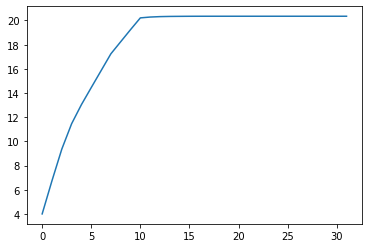

In [23]:
plt.plot(np.cumsum(svd(torch.nn.functional.softmax(q[0][0], dim=-1).detach().numpy())))
# plt.plot(np.cumsum(q_[0][0][0]))

In [36]:
svd_trunc =  TruncatedSVD(n_components = 20)
q_transf = svd_trunc.fit_transform(q.detach().numpy()[0][0])

In [37]:
np.array(q_transf).shape

(49, 20)

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


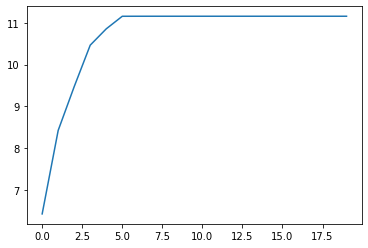

In [39]:
plt.plot(np.cumsum(svd(torch.nn.functional.softmax(torch.tensor(q_transf)))))

In [41]:
layers_3_blocks_0_attn_qkv_weight.shape

torch.Size([2304, 768])

In [90]:
layers_3_blocks_0_attn_qkv_weight.T.shape

torch.Size([768, 2304])

In [92]:
u,s,v = np.linalg.svd(layers_3_blocks_0_attn_qkv_weight, compute_uv=True)

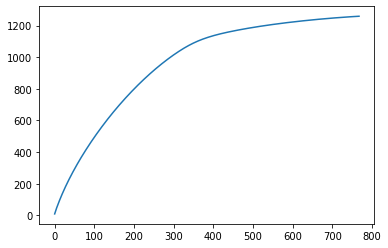

In [89]:
plt.plot(np.cumsum(svd(layers_3_blocks_0_attn_qkv_weight.T)))

In [24]:
layers_3_blocks_0_attn_qkv_weight.shape

torch.Size([2304, 768])

In [25]:
qkv_w = layers_3_blocks_0_attn_qkv_weight.T.reshape(768, 3, 2304//3).permute(1,0,2)

In [26]:
layers_3_blocks_0_attn_qkv_weight.shape

torch.Size([2304, 768])

Text(0, 0.5, 'Cumulative eigenvalue')

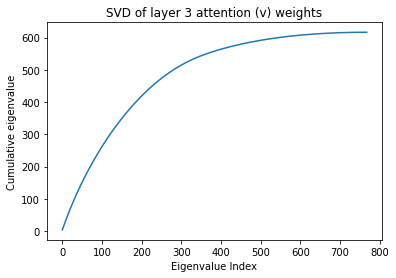

In [28]:
plt.plot(np.cumsum(svd(v_w)))
plt.title("SVD of layer 3 attention (v) weights")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cumulative eigenvalue")
# plt.plot(np.cumsum(svd(torch.nn.functional.softmax(q_w, dim=-1).detach().numpy())))

In [32]:
tmpw = model.state_dict()['layers.3.blocks.0.mlp.fc1.weight']
print(tmpw.shape)

torch.Size([3072, 768])


Text(0, 0.5, 'Cumulative eigenvalue')

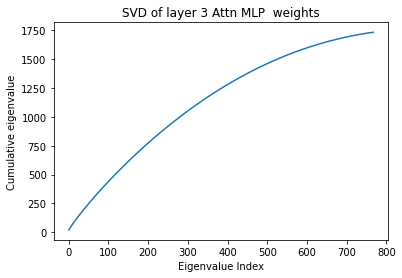

In [33]:
plt.plot(np.cumsum(svd(tmpw)))
plt.title("SVD of layer 3 Attn MLP  weights")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cumulative eigenvalue")


In [34]:
tmpw = model.state_dict()['layers.3.blocks.0.attn.proj.weight']
print(tmpw.shape)

torch.Size([768, 768])


Text(0, 0.5, 'Cumulative eigenvalue')

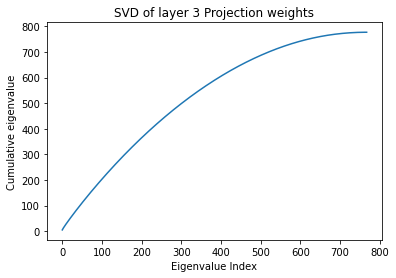

In [35]:

plt.plot(np.cumsum(svd(tmpw)))
plt.title("SVD of layer 3 Projection weights")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cumulative eigenvalue")


In [38]:
tmpw = model.state_dict()['layers.2.downsample.reduction.weight']
print(tmpw.shape)

torch.Size([768, 1536])


Text(0, 0.5, 'Cumulative eigenvalue')

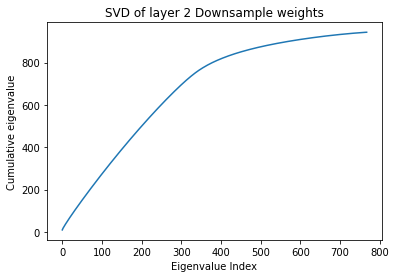

In [39]:
plt.plot(np.cumsum(svd(tmpw)))
plt.title("SVD of layer 2 Downsample weights")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cumulative eigenvalue")

In [27]:
# qkv_w = layers_3_blocks_0_attn_qkv_weight.reshape(2304, 3, 768//3).permute(1,0,2)
q_w = qkv_w[0]
k_w = qkv_w[1] 
v_w = qkv_w[2] 

In [88]:
qkv_w.shape

torch.Size([3, 2304, 256])

In [119]:
v_w.shape

torch.Size([768, 768])

In [79]:
u,s,v = np.linalg.svd(q_w, compute_uv=True)
# svd(torch.nn.functional.softmax(q_w), full_matrices=True)

In [85]:
max(s)

5.7457476

In [120]:
uPrime, sPrime, vPrime = np.linalg.svd(v_w, full_matrices=False, compute_uv=True)


In [121]:
print(uPrime.shape, sPrime.shape, vPrime.shape)

(768, 768) (768,) (768, 768)


In [123]:
trunc_val = 350

In [124]:
low_rank_vw = uPrime[:, :trunc_val] @ np.diag(sPrime[:trunc_val]) @ vPrime[:trunc_val, :]

In [127]:
uPP = uPrime[:, :trunc_val] @ np.diag(sPrime[:trunc_val])
uPP.shape

(768, 350)

In [130]:
vPrime[:trunc_val, :].shape

(350, 768)

In [128]:
v_w.shape

torch.Size([768, 768])

In [125]:
low_rank_vw

array([[-0.02858894,  0.01302148,  0.01605037, ..., -0.01522799,
         0.06054224, -0.02956625],
       [-0.0206921 ,  0.01478771,  0.01176441, ..., -0.06309901,
         0.02963198, -0.02792705],
       [-0.0121218 ,  0.01902911, -0.06406058, ...,  0.038522  ,
         0.07085029,  0.03507822],
       ...,
       [ 0.05346682, -0.07752582, -0.07120977, ...,  0.02387831,
        -0.03859507,  0.02546671],
       [ 0.05451753, -0.00110611, -0.00948278, ...,  0.00569572,
        -0.05594096,  0.01312127],
       [-0.07931267,  0.08638148, -0.03543062, ..., -0.03379454,
        -0.06551757, -0.01829359]], dtype=float32)

In [104]:
lora_qkv  = (uPrime * sPrime) @ vPrime
np.allclose(layers_3_blocks_0_attn_qkv_weight, lora_qkv)

False

In [108]:
print(layers_3_blocks_0_attn_qkv_weight[1][1], lora_qkv[1][1])

tensor(0.0785) 0.07854651


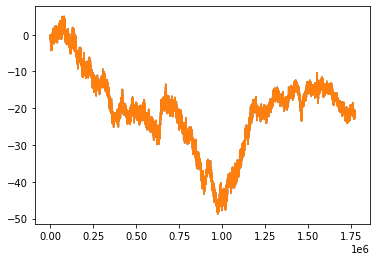

In [99]:
plt.plot(np.cumsum(layers_3_blocks_0_attn_qkv_weight))
plt.plot(np.cumsum(lora_qkv))

In [87]:
np.linalg.matrix_rank(qkv_w, tol=0.9)

array([220, 222, 222])

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


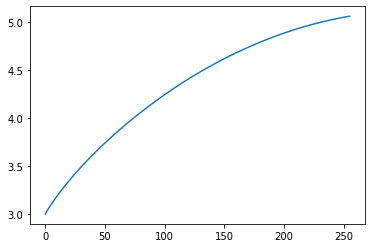

In [77]:
plt.plot(np.cumsum(svd(torch.nn.functional.softmax(q_w))))

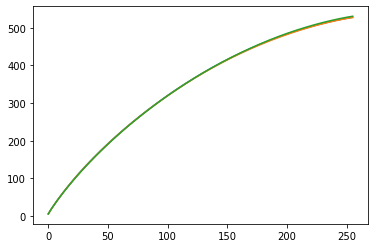

In [68]:
plt.plot(np.cumsum(svd(q_w)))
plt.plot(np.cumsum(svd(k_w)))
plt.plot(np.cumsum(svd(v_w)))

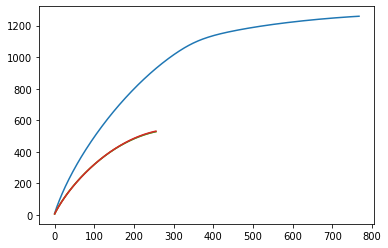

In [66]:
plt.plot(np.cumsum(svd(layers_3_blocks_0_attn_qkv_weight)))
plt.plot(np.cumsum(svd(q_w)))
plt.plot(np.cumsum(svd(k_w)))
plt.plot(np.cumsum(svd(v_w)))

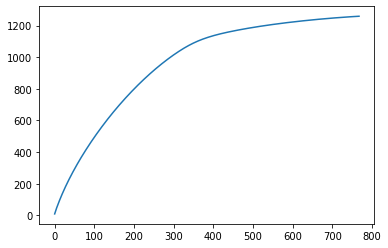

In [96]:
plt.plot(np.cumsum(svd(layers_3_blocks_0_attn_qkv_weight)))

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


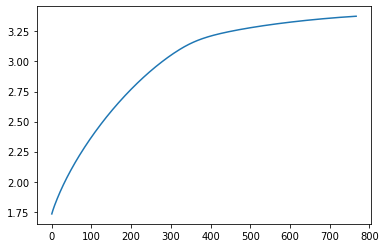

In [42]:
plt.plot(np.cumsum(svd(torch.nn.functional.softmax(layers_3_blocks_0_attn_qkv_weight))))

In [53]:
svd_w = svd(layers_3_blocks_0_attn_qkv_weight)

In [56]:
svd_w.shape

(768,)

In [57]:
rank_r = np.argwhere(x > (0.8 * np.max(svd_w)))
print(rank_r)

tensor([[   0,    0,    0,  ..., 1023, 1023, 1023],
        [   0,    0,    0,  ...,   48,   48,   48],
        [   1,    2,    4,  ...,  764,  765,  766]])


In [109]:
svd_trunc =  TruncatedSVD(n_components = 768)
w_transf = svd_trunc.fit_transform(layers_3_blocks_0_attn_qkv_weight.T.detach().numpy())

In [110]:
w_transf.shape

(768, 768)

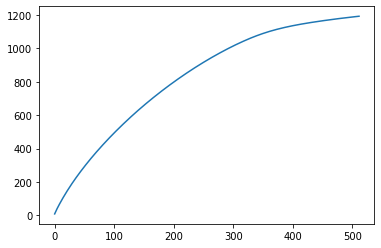

In [44]:
plt.plot(np.cumsum(svd(w_transf)))

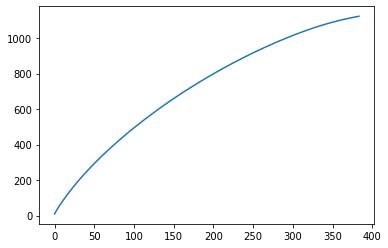

In [46]:
plt.plot(np.cumsum(svd(w_transf)))

In [25]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

A = np.array([[-1, 2, 0], [2, 0, -2], [0, -2, 1]])
print("Original Matrix:")
print(A)

svd =  TruncatedSVD(n_components = 2)
A_transf = svd.fit_transform(A)

print("Singular values:")
print(svd.singular_values_)

print("Transformed Matrix after reducing to 2 features:")
print(A_transf)

Original Matrix:
[[-1  2  0]
 [ 2  0 -2]
 [ 0 -2  1]]
Singular values:
[3. 3.]
Transformed Matrix after reducing to 2 features:
[[-1.78885438e+00 -1.34164079e+00]
 [-8.94427191e-01  2.68328157e+00]
 [ 2.23606798e+00  2.22044605e-16]]


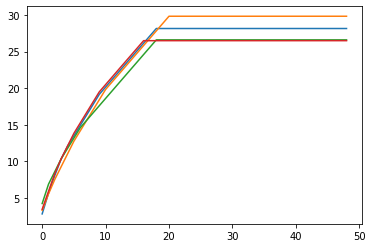

In [28]:
for i in range(0, q_.shape[1], 256):
    plt.plot(np.argmax(np.cumsum(svd(q_[0][i]))), label = "attn output")

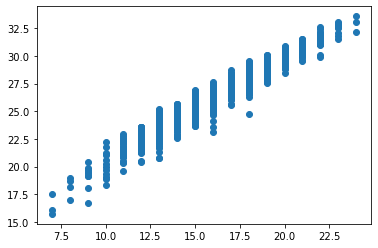

In [34]:

across_heads_x = []
for j in range(0, q_.shape[0], 1):
    x = []
    y = []
    for i in range(0, q_.shape[1], 1):
        a = np.cumsum(svd(q_[0][i]))
        # print(len(a))
        idx = np.argmax(a)
        x.append(idx)
        y.append(a[idx])
        # plt.plot(a[idx], label = "attn output")
    across_heads_x.append(np.percentile(x,80))
# plt.scatter(x, y)
# plt.show()

In [36]:
across_heads_x = []
for j in range(0, q_.shape[0], 1):
    x = []
    y = []
    for i in range(0, q_.shape[1], 1):
        a = np.cumsum(svd(q_[j][i]))
        # print(len(a))
        idx = np.argmax(a)
        x.append(idx)
        y.append(a[idx])
        # plt.plot(a[idx], label = "attn output")
    across_heads_x.append(np.percentile(x,80))

In [37]:
print("Mean = ", np.mean(across_heads_x))
print("90th percentile = ", np.percentile(across_heads_x, 90))
print("80th percentile = ", np.percentile(across_heads_x, 80))

Mean =  20.166666666666668
90th percentile =  22.7
80th percentile =  21.0


In [35]:
np.percentile(x,80)

19.0

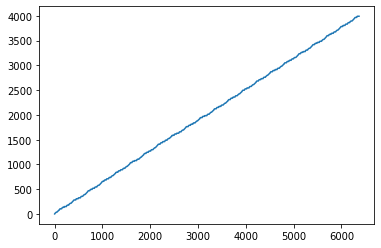

In [141]:
plt.plot(np.cumsum(svd(attn_op.detach().numpy())))

In [63]:
model.state_dict()['relative_position_bias_table']

KeyError: 'relative_position_bias_table'

In [64]:
relative_position_bias_table_keys = [k for k in model.state_dict().keys() if "relative_position_bias_table" in k]

In [65]:
relative_position_bias_table_keys

['layers.0.blocks.0.attn.relative_position_bias_table',
 'layers.0.blocks.1.attn.relative_position_bias_table',
 'layers.1.blocks.0.attn.relative_position_bias_table',
 'layers.1.blocks.1.attn.relative_position_bias_table',
 'layers.2.blocks.0.attn.relative_position_bias_table',
 'layers.2.blocks.1.attn.relative_position_bias_table',
 'layers.2.blocks.2.attn.relative_position_bias_table',
 'layers.2.blocks.3.attn.relative_position_bias_table',
 'layers.2.blocks.4.attn.relative_position_bias_table',
 'layers.2.blocks.5.attn.relative_position_bias_table',
 'layers.3.blocks.0.attn.relative_position_bias_table',
 'layers.3.blocks.1.attn.relative_position_bias_table']

In [30]:
x_windows = x_windows.view(-1, window_size * window_size, C)

In [31]:
x_windows.shape

torch.Size([10240, 49, 96])

In [32]:
x = x_windows
B_, N, C = x.shape
qkv_layer = torch.nn.Linear(C, C * 3, bias=True)

In [43]:
params = qkv_layer.named_parameters()
copy_params = [(m[1], m[0]) for m in qkv_layer.named_parameters()]
print(qkv_layer.state_dict()['weight'].shape)

torch.Size([288, 96])


In [33]:
layers_0_blocks_0_attn_qkv_weight = model.state_dict()['layers.0.blocks.0.attn.qkv.weight']

In [44]:
def get_model_weight(weight_name):
    return model.state_dict()[weight_name]

In [46]:
import copy

new_sd = copy.deepcopy(qkv_layer.state_dict())
new_sd['weight'] = get_model_weight('layers.0.blocks.0.attn.qkv.weight')
new_sd['bias'] = get_model_weight('layers.0.blocks.0.attn.qkv.bias')
qkv_layer.load_state_dict(new_sd)

<All keys matched successfully>

In [47]:
relative_position_bias_table = torch.nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

In [50]:
relative_position_bias_table.state_dict()

AttributeError: 'Parameter' object has no attribute 'state_dict'

In [34]:
layers_0_blocks_0_attn_qkv_weight.shape

torch.Size([288, 96])

In [ ]:
qkv =qkv_layer(x).reshape(B_, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)

In [24]:
x_windows.shape

torch.Size([10240, 49, 96])

In [10]:
layers_0_blocks_1_attn_qkv_weight.size()


torch.Size([288, 96])

In [15]:
m = np.random.rand(1,96)
m.shape

(1, 96)

In [15]:
m.shape

(1, 96)

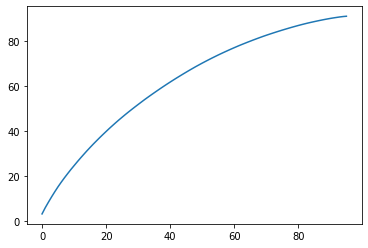

In [13]:
# plt.plot(svd(m))

plt.plot(np.cumsum(svd(layers_0_blocks_1_attn_qkv_weight.numpy())))
# plt.show()

In [23]:
(m.T).size()

TypeError: 'int' object is not callable

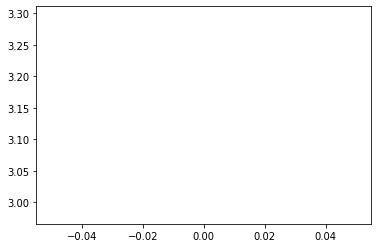

In [16]:
plt.plot(np.cumsum(svd(layers_0_blocks_1_attn_qkv_weight.numpy() @ m.T)))